# ChemCharts JSON Plot 

## PREPARATION 
Bevor using this notebook dependencies need to be loaded and paths updated.

In [1]:
# load dependencies
import os
import json
import tempfile
from IPython.display import Image

# change these paths to match your system's configuration
chemcharts_dir = os.path.expanduser("~/Documents/Projects/ChemCharts") # set project folder on your device
chemcharts_env = os.path.expanduser("~/miniconda3/envs/chemcharts")    # set environment path on your device
output_dir = os.path.expanduser("~/Desktop/chemcharts_json_test")      # set output path on your device

# do NOT change me
try: ipynb_path                                                   
except NameError: ipynb_path = os.getcwd()                             # sets root path

try:
    os.mkdir(output_dir)                                               # checks whether there is an output folder 
except FileExistsError:                                                # and generates one if there isn't one already available
    pass


## INITIALIZATION 
The following cells with construct a `JSON` configuration file step-by-step by adding options to a dictionary, which is the written out to a file. Afterwards, this configuration file is used to run `ChemCharts`.

In [2]:

conf={"chemcharts": {}}


### Header 
Add a header if needed.

In [3]:

conf={
  "chemcharts": {
    "header": {}                                                        # leave empty if not needed
  }
}


## EXECUTION
### Data loading
Now you can start adding tasks to the config file. Data loading is the obligatory first step. Note, that you can also load previous, pickled and pre-processed data files. The column names used below conform to the `REINVENT` scaffold memory format.

In [4]:

conf["chemcharts"]["execution"] = [
      {"task":  "data_loading",
       "input":  os.path.join(chemcharts_dir, "data/scaffold_memory.csv"),
       "input_type":  "csv",
       "columns":  {
                     "smiles_column": "SMILES",
                     "scores_column": "total_score",
                     "epochs_column": "Step"
                    }
      }]
    

### Generate fingerprints
Once the data is loaded, we need to translate the chemical strings (SMILES) into fingerprints. There are a couple of different options, here we will use MACCS.

In [5]:

conf["chemcharts"]["execution"].append(
      {"task":  "generate_fingerprints",
       "type":  "maccs",                                                # you can choose between standard, morgan and maccs
       "parameters":  {"useFeatures": True}                             # with the other two fingerprints there are no parameters
      })


### Dimensional reduction
Reduces the number of features in your dataset with an UMP algorithm.

In [6]:

conf["chemcharts"]["execution"].append(
      {"task":  "dimensional_reduction",
       "type": "UMAP",
       "parameters":  {}
      })


### Optional: Filtering
You can define a filter range to reduce the input to the data within the range. These operate on the embedded dimensions UMAP1 and UMAP2.

In [7]:

conf["chemcharts"]["execution"].append(
      {"task":  "filtering_data",
       "type": "filtering",
       "parameters":  {"range_dim1": [-100, 100],                       # set range for UMAP_1
                       "range_dim2": [-100, 100]}                       # set range for UMAP_2
      })


### Optional: Clustering
You can further prepare the data by clustering it with KMeans.

In [8]:

conf["chemcharts"]["execution"].append(
      {"task":  "clustering_data",
       "type": "KMmeans",
       "parameters":  {"k": 10}                                         # set the number of desired KMeans clusters
      })


### Optional: Binning
You might also want to bin the scores and return their median in order to "flatten" the score surface.

In [9]:

conf["chemcharts"]["execution"].append(
      {"task":  "binning_scores",
       "type": "binning",
       "parameters":  {"num_bins": 4}                                    # set the number of desired bins
      })


### Write-Out
When using large data sets it is advisable to write out the updated data and use the thereby generated `pkl` file as input later.

In [10]:

# write-out of data into a pkl file
conf["chemcharts"]["execution"].append({
        "task": "write_out",
        "format": "pkl",
        "path": os.path.join(output_dir, "simple_plot_test.pkl")           # choose loaction for ".pkl" file
      })

In [11]:
# write-out of configuration file
conf_preprocess_JSON_path = os.path.join(output_dir, "chemcharts_preprocess_data.json")
with open(conf_preprocess_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)

In [12]:
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {conf_preprocess_JSON_path}

Traceback (most recent call last):
  File "/home/nutzer/Documents/Projects/ChemCharts/chemcharts_json.py", line 88, in <module>
    groups_column = task[_JE.COLUMNS][_JE.GROUPS_COLUMN]
KeyError: 'groups_column'


## PLOT GENERATION
### Example: Hexagonal plot generation
Once the updated data is saved in a pkl file you can start generating various plots.

In [13]:

# now you can load the data from the pkl file and generate the plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             # choose plot type (here: Hexagonal)
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 # set plot title (default: Hexagonal Chemcharts Plot)
                       "gridsize": 20,                                       # set gridsize {default: 20}
                       "fontsize": 14,                                       # set fontsize of dataset title (default: 14) 
                       "top": 0.9,                                           # set top margin (default: 0.9)    
                       "color": "#4CB391"},                                  # set marker color (default: #4CB391)
        "settings": {"path": os.path.join(output_dir, "hexagonal_plot.png"), # set output path including file name
                     "format": "png",                                        # set file format (default: png)  
                     "dpi": 150,                                             # set dpi (default: 150)
                     "figsize": [8, 8]}                                      # set figure size (default: [8, 8]) 
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True) 
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {configuration_JSON_path}

Task data_loading completed.
Task generate_plot completed.


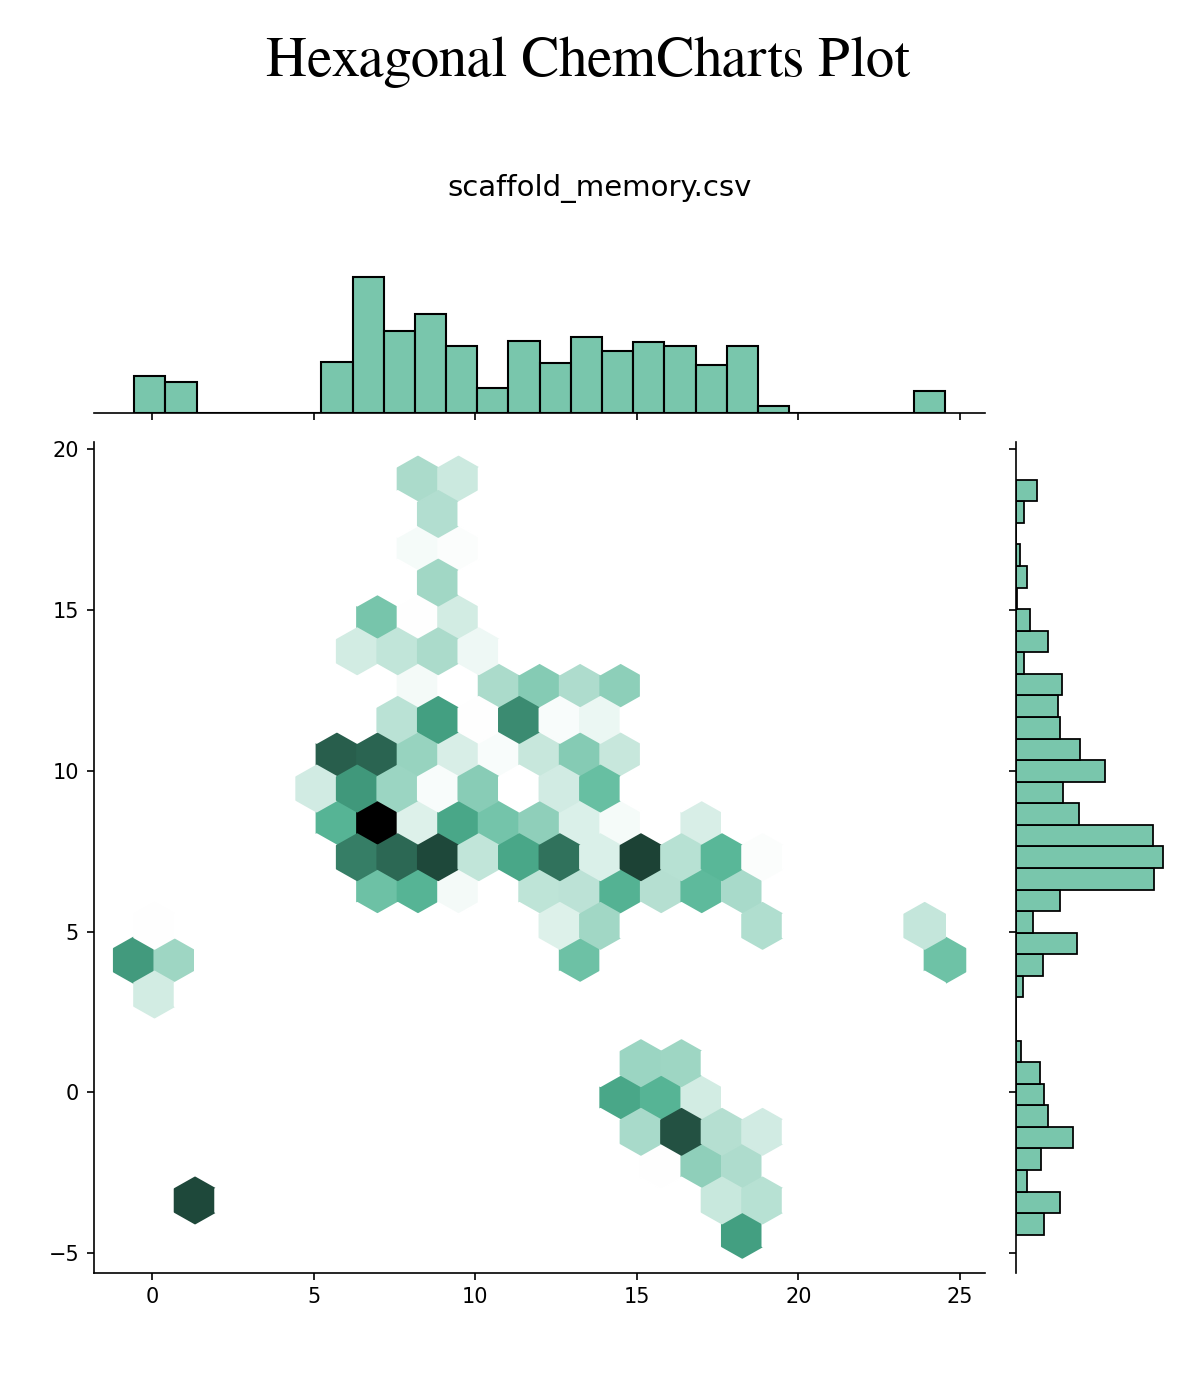

In [14]:

# display hexagonal plot 
Image(filename=os.path.join(output_dir, "hexagonal_plot.png"), width=400, height=200)      # with width and height you can alternate the displayed image size

### Example: Hexagonal plot generation with defined xlim and ylim
The parameters xlim and ylim allow to define an excerpt for the plot.

In [15]:

# plot generation with defined xlim and ylim
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 
                       "gridsize": 20,                                       
                       "fontsize": 14,                                        
                       "top": 0.9,                                           
                       "xlim": [-6.5, 14],                                   # set xlim
                       "ylim": [-9, 12],                                     # set ylim   
                       "color": "#4CB391"},                                  
        "settings": {"path": os.path.join(output_dir, "hexagonal_xlim_ylim_plot.png"), 
                     "format": "png",                                          
                     "dpi": 150,                                             
                     "figsize": [8, 8]}                                                                                  
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {configuration_JSON_path}

Task data_loading completed.
Task generate_plot completed.


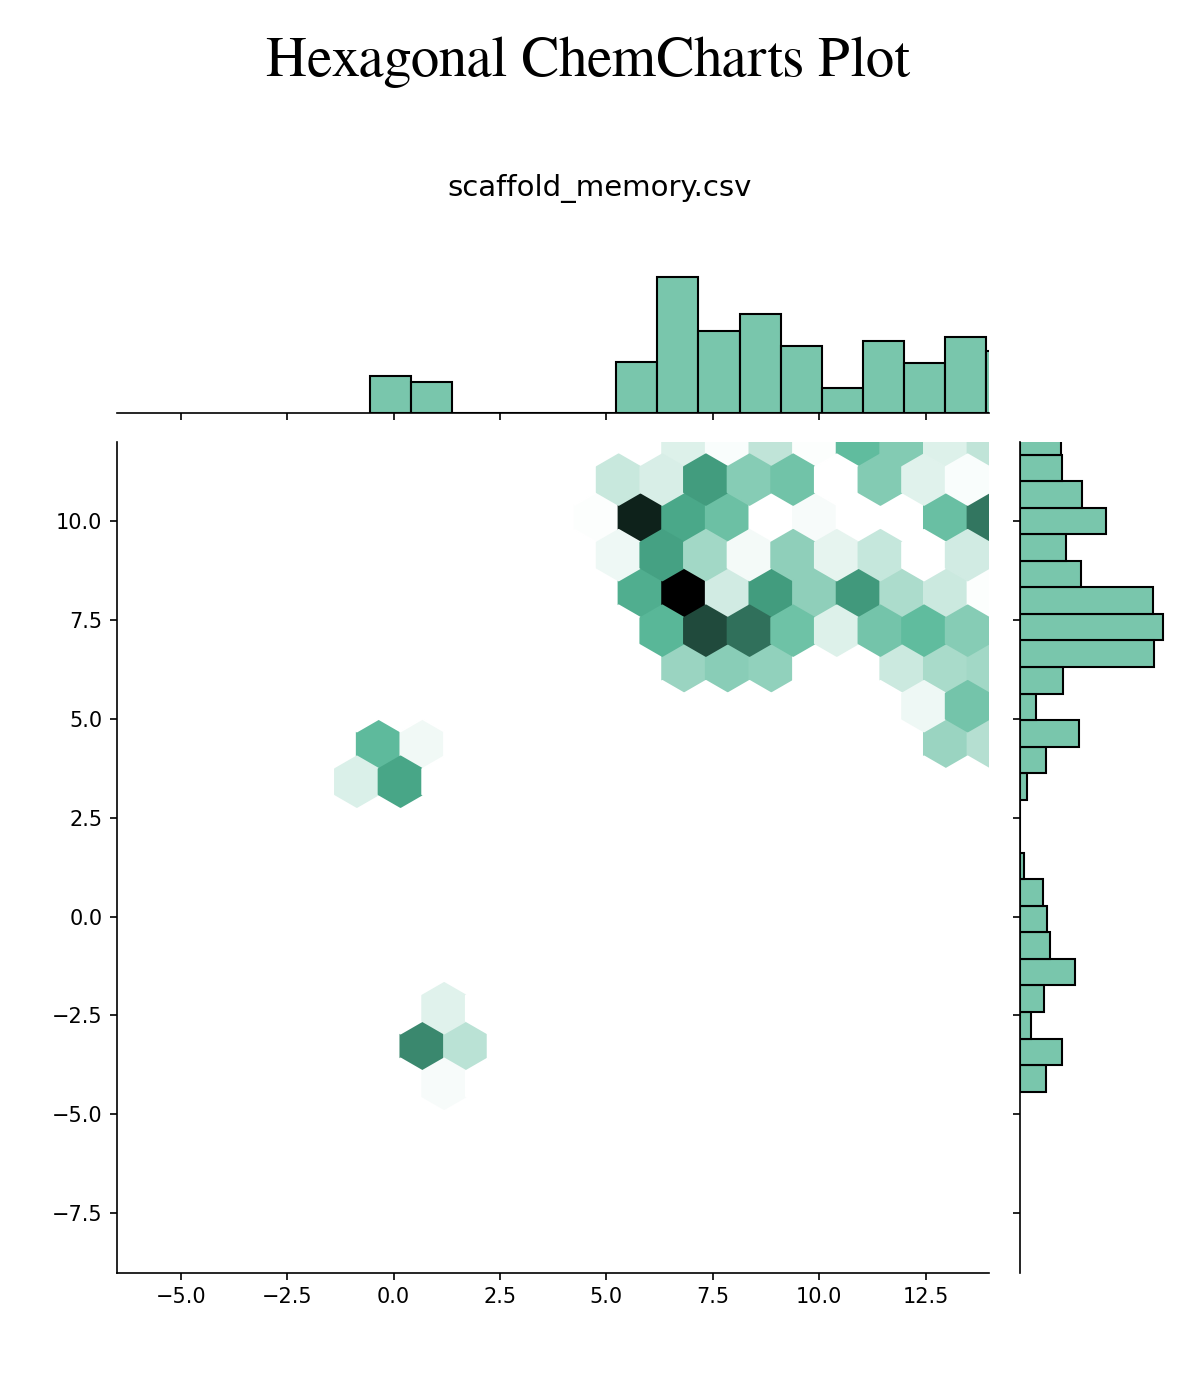

In [16]:

# display hexagonal plot with defined xlim and ylim
Image(filename=os.path.join(output_dir, "hexagonal_xlim_ylim_plot.png"), width=400, height=200)      # with width and height you can alternate the displayed image size

### Example: Multiple plot generation
You can also generate multiple plots at once.

In [17]:

# generates a hexagonal and histogram plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "histogram_plot",                                              # choose plot type (here: Histogram)
       "parameters":  {"title": "Histogram ChemCharts Plot",                  # set plot title (default: Histogram Chemcharts Plot)
                       "bins": 20,                                            # set bin number {default: 20}
                       "fontsize": 14,                                        # set fontsize of dataset title (default: 14) 
                       "top": 0.9,                                            # set top margin (default: 0.9)
                       "color": "#d11d80"},                                   # set marker color (default: #d11d80)
       "settings": {"path": os.path.join(output_dir, "histogram_plot.png"),   # set output path including file name
                    "format": "png",                                          # set file format (default: png)  
                    "dpi": 300,                                               # set dpi (default: 300)
                    "figsize": [7, 7]}                                        # set figure size (default: [7, 7])
      },
      {"task": "generate_plot",
       "type": "scatter_interactive_plot",
       "parameters":  {"title": "Scatter Interactive ChemCharts Plot",                # set plot title (default: Scatter Interactive Chemcharts Plot)
                       "marker_size": 1},                                             # set marker size (default: 1)
       "settings": {"path": os.path.join(output_dir, "scatter_interactive_plot.png"), # set output path including file name
                    "view": True,                                                     # set view on true if pop-up window is desired (default: false)
                    "format": "png",                                                  # set file format (default: png) 
                    "figsize": [900, 900]}                                            # set figure size (default: [900, 900])
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
#execution
!{chemcharts_env}/bin/python {chemcharts_dir}/chemcharts_json.py -conf {configuration_JSON_path}

Task data_loading completed.
Task generate_plot completed.
Function does not (yet) support multiple input objects.
Task generate_plot completed.


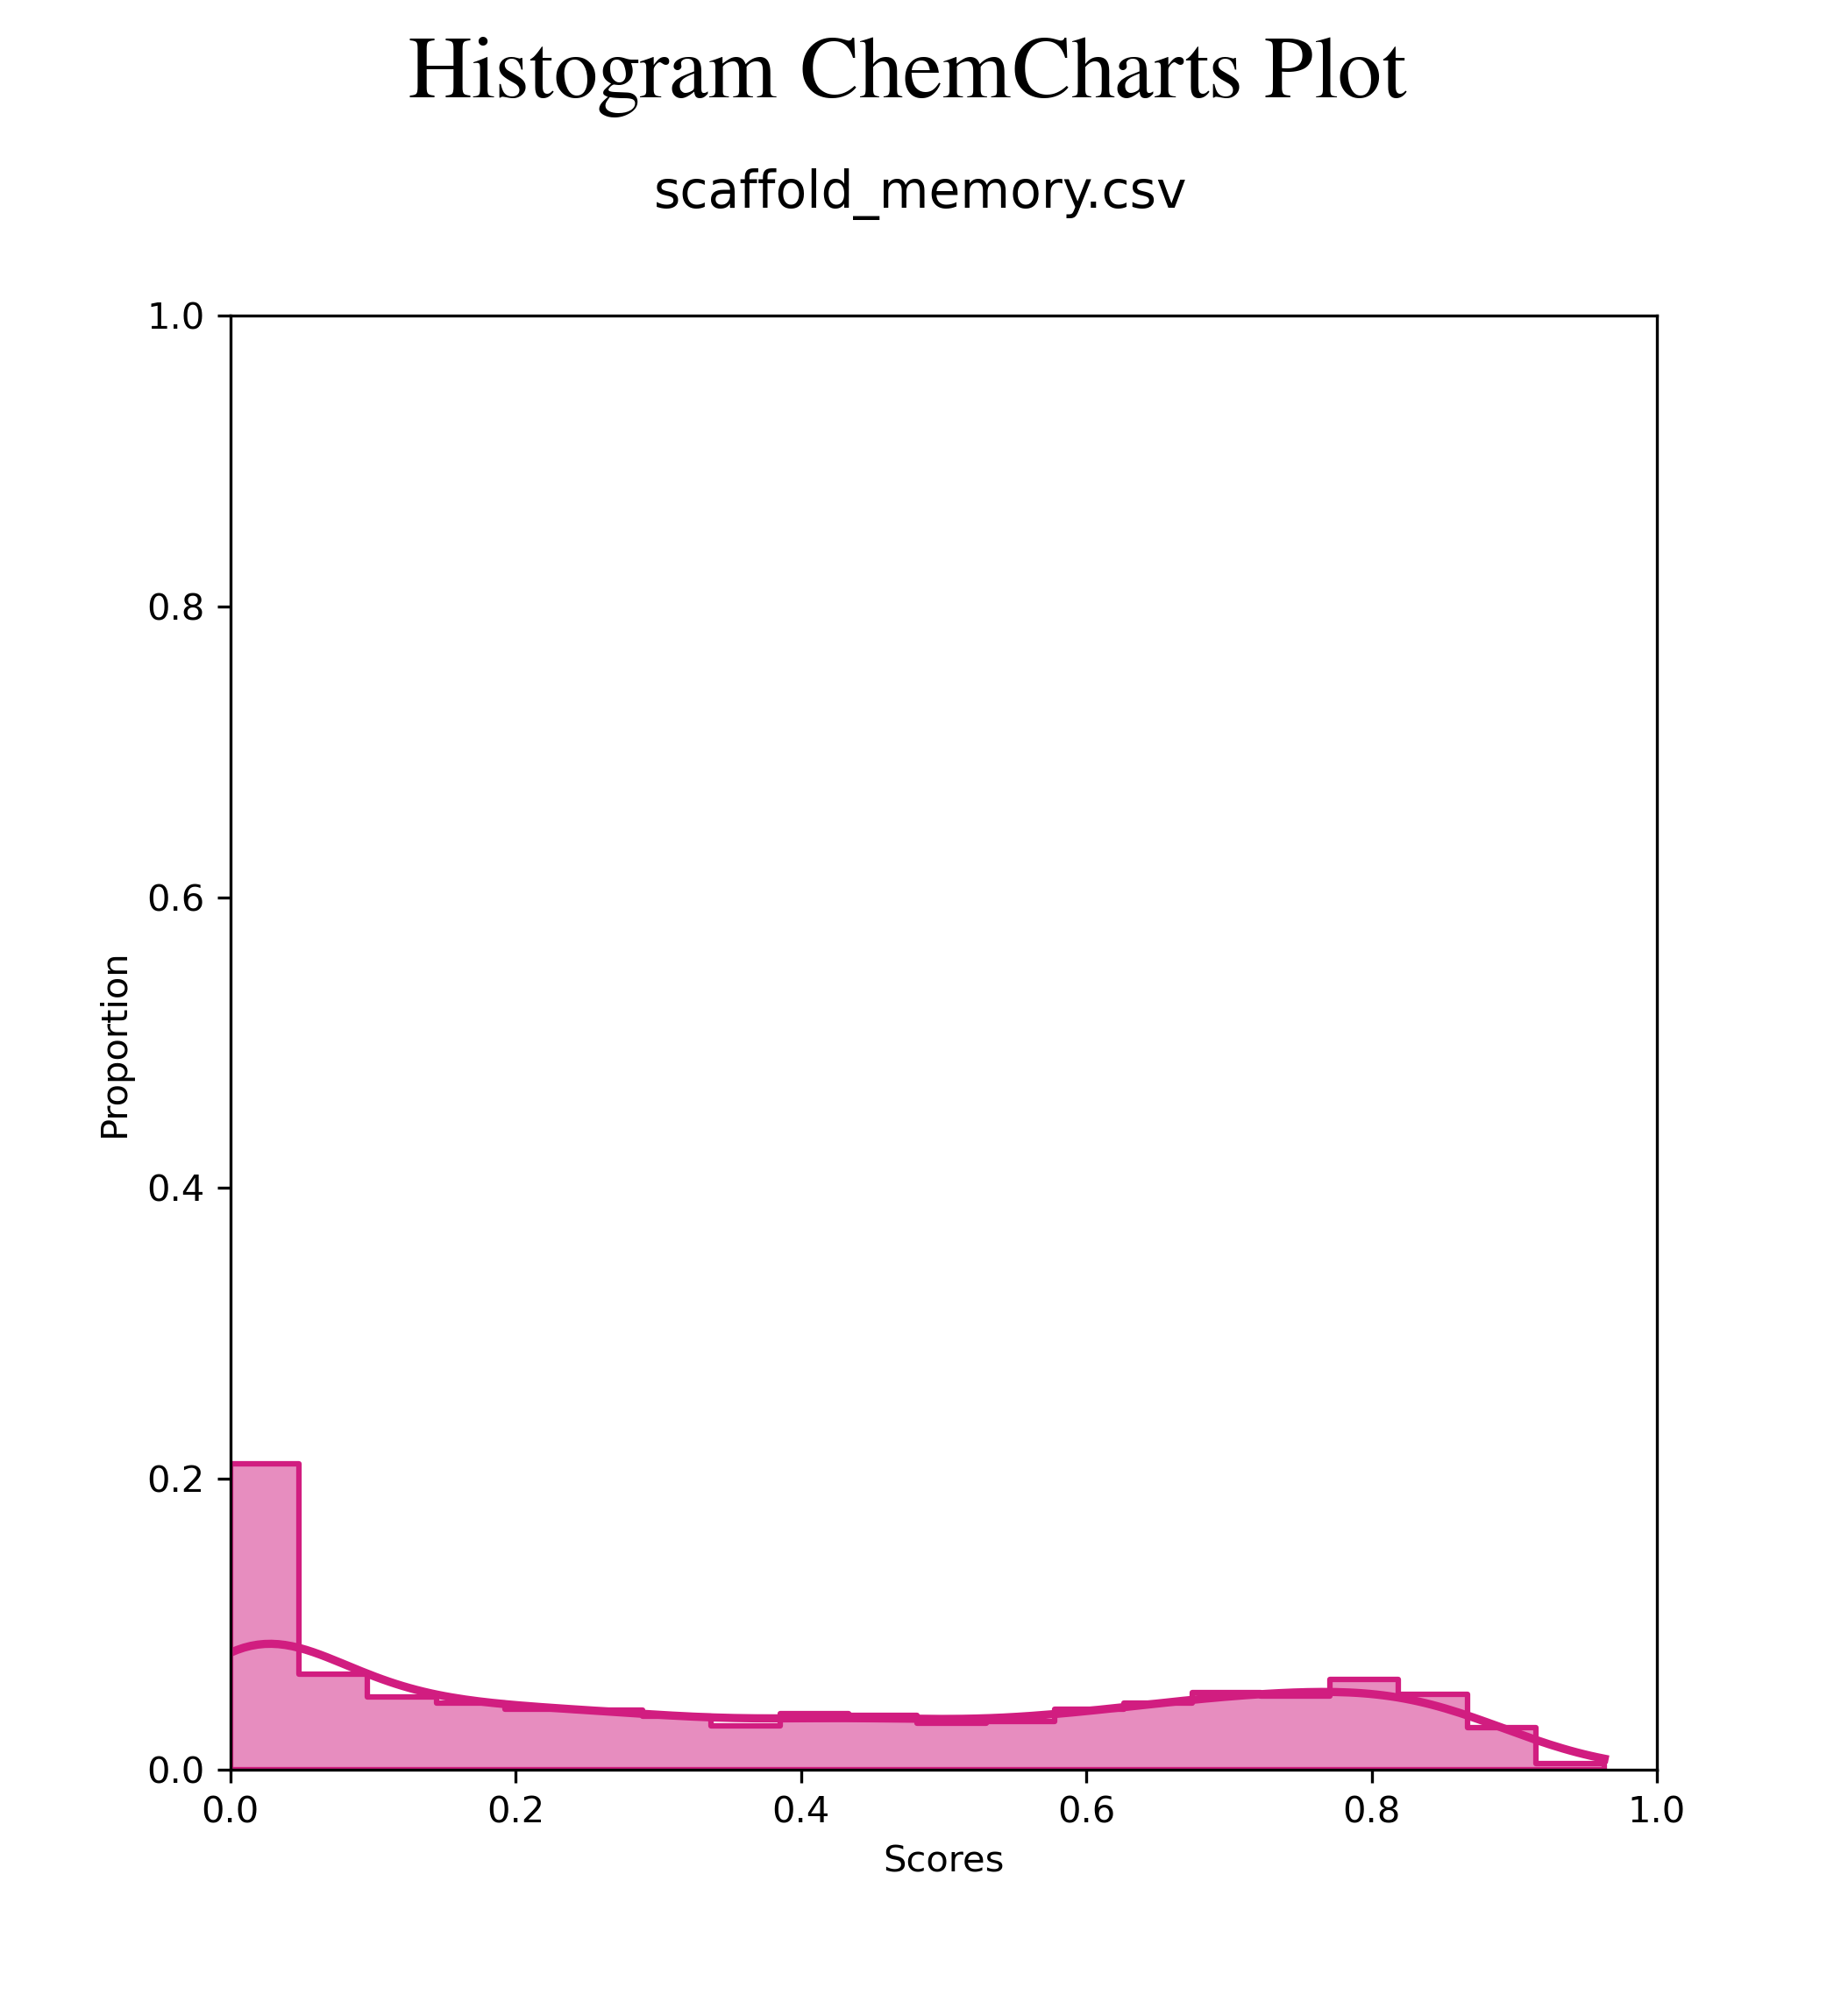

In [18]:

# display histogram plot
Image(filename=os.path.join(output_dir, "histogram_plot.png"), width=400, height=200)

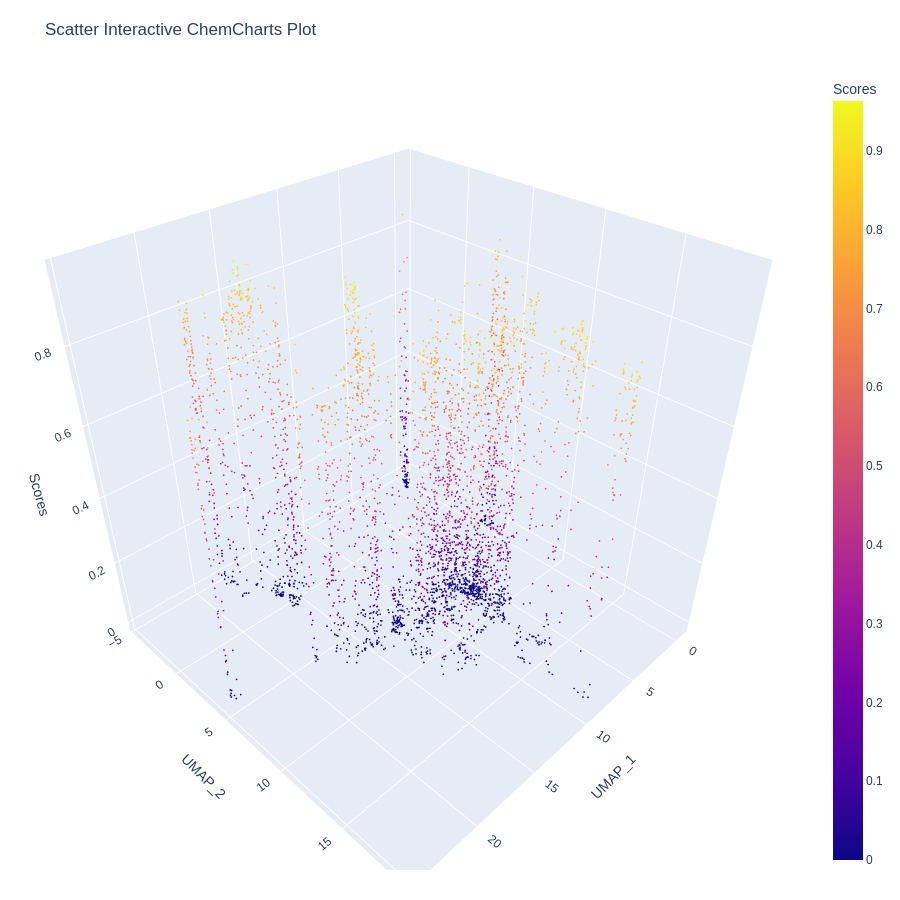

In [19]:

# display scatter_interactive plot
Image(filename=os.path.join(output_dir, "scatter_interactive_plot.png"), width=600, height=300)      # with width and height you can alternate the displayed image size     


## PLOT VARIANTS
ChemCharts can generate multiple plot variants: 

In [ ]:
 
    # Scatter Boxplot

     {"task": "generate_plot",
       "type": "scatter_boxplot_plot",
       "parameters":  {"title": "Scatter Boxplot ChemCharts Plot",                   # set plot title (default: Scatter Boxplot Chemcharts Plot)
                       "fontsize": 14,                                               # set fontsize of dataset title (default: 14) 
                       "top": 0.9},                                                  # set top margin (default: 0.9)
        "settings": {"path": os.path.join(output_dir, "scatter_boxplot_plot.png"),   # set output path including file name
                     "format": "png",                                                # set file format (default: png) 
                     "dpi": 150,                                                     # set dpi (default: 150)
                     "figsize": [6, 6]                                               # set figure size (default: [6, 6])
                     "boxplot": True,                                                # set boxplot on true if setting is desired (default: False)
                     "group_name": "Molecule_groups"}                                # choose legend name for group colouring (default: groups) 
     }
    
        
    # Scatter Static
    
      {"task": "generate_plot",
       "type": "scatter_static_plot",
       "parameters":  {"title": "Scatter Static ChemCharts Plot",                     # set plot title (default: Scatter Static Chemcharts Plot)
                       "color": "#0000ff",                                            # set marker color (default: #0000ff)
                       "s": 1},                                                       # set marker size (default: 6)
        "settings": {"path": os.path.join(output_dir, "scatter_static_plot.png"),     # set output path including file name
                     "format": "png",                                                 # set file format (default: png) 
                     "dpi": 150,                                                      # set dpi (default: 150)
                     "figsize": [5, 5]}                                               # set figure size (default: [5, 5])
      }
    
    
    # Trisurf Interactive
    
      {"task": "generate_plot",
       "type": "trisurf_interactive_plot",
       "parameters":  {"title": "Trisurf Interactive ChemCharts Plot",                 # set plot title (default: Trisurf Interactive Chemcharts Plot)
                       "color": "Portland"},                                           # set plotly built-in continuous color scales (default: Portland)
       "settings": {"path": os.path.join(output_dir, "trisurf_interactive_plot.png"),  # set output path including file name
                    "view": True,                                                      # set view on true if pop-up window is desired (default: false)
                     "format": "png"}                                                  # set file format (default: png) 
                     "figsize": [900, 900]}                                            # set figure size (default: [900, 900])
      }
       
        
    # Trisurf Static
    
      {"task": "generate_plot",
       "type": "trisurf_static_plot",
       "parameters":  {"title": "Trisurf Static ChemCharts Plot",                       # set plot title (default: Trisurf Static Chemcharts Plot)
                       "color": "gist_rainbow"},                                        # set matplotlib colormap (default: gist_rainbow)
        "settings": {"path": os.path.join(output_dir, "trisurf_static_plot.png"),       # set output path including file name
                     "format": "png",                                                   # set file format (default: png) 
                     "dpi": 150,                                                        # set dpi (default: 150)
                     "figsize": [5, 5]}                                                 # set figure size (default: [5, 5])
      }
    